In [1]:
!pip install tqdm

In [2]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import os

#全局参数，随机种子
seed = 114514
np.random.seed(seed)
random.seed(seed)

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print("【device】",device)

【device】 cuda:0


## 数据准备

In [3]:
df = pd.read_csv('/kaggle/input/book-recommend-datasets/datasets/train.csv')
print('【训练集】共{}个用户，{}本图书，{}条记录'.format(max(df['user_id'])+1, max(df['item_id'])+1, len(df)))

【训练集】共53424个用户，10000本图书，5869631条记录


In [4]:
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,user_id,item_id
0,0,257
1,0,267
2,0,5555
3,0,3637
4,0,1795


构建Dataset类
构建负样本
划分测试集与验证集
构建对应的Dataloader

In [5]:
import tqdm
class Goodbooks(Dataset):
    def __init__(self, df, mode='training',load_1=None,load_2=None,negs = 99):
        super().__init__()

        self.df = df
        self.mode = mode

        self.book_nums = max(df['item_id'])+1
        self.user_nums = max(df['user_id'])+1
        if load_1==None:
            self._init_dataset()
        else:
            self.user_book_map=load_1
            self.Xs=load_2
            
    def _init_dataset(self):
        self.Xs = []
        self.user_book_map = {}
        
        print("【user_nums】",self.user_nums)
        
        for i in range(self.user_nums):
            self.user_book_map[i] = []

        for index, row in tqdm.tqdm(self.df.iterrows()):
            user_id, book_id = row
            self.user_book_map[user_id].append(book_id)

        if self.mode == 'training':
            for user, items in tqdm.tqdm(self.user_book_map.items()):
                for item in items[:-1]:
                    self.Xs.append((user, item, 1))
                    for _ in range(3):
                        while True:
                            neg_sample = random.randint(0, self.book_nums-1)
                            if neg_sample not in self.user_book_map[user]:
                                self.Xs.append((user, neg_sample, 0))
                                break

        elif self.mode == 'validation':
            for user, items in tqdm.tqdm(self.user_book_map.items()):
                if len(items) == 0:
                    continue
                self.Xs.append((user, items[-1]))

    def __getitem__(self, index):

        if self.mode == 'training':
            user_id, book_id, label = self.Xs[index]
            return user_id, book_id, label
        elif self.mode == 'validation':
            user_id, book_id = self.Xs[index]

            negs = list(random.sample(
                list(set(range(self.book_nums)) - set(self.user_book_map[user_id])),
                k=99
            ))
            return user_id, book_id, torch.LongTensor(negs)

    def __len__(self):
        return len(self.Xs)

In [ ]:
#建立训练和验证dataloader
traindataset = Goodbooks(df, 'training')
print("训练集处理完毕")
validdataset = Goodbooks(df, 'validation')
print("测试集处理完毕")

np.save('train_map.npy', traindataset.user_book_map)
np.save('train_Xs.npy', traindataset.Xs)
np.save('valid_map.npy', validdataset.user_book_map)
np.save('valid_Xs.npy', validdataset.Xs)

In [6]:
load_1 = np.load('/kaggle/input/book-recommend-datasets/mapXs/train_map.npy',allow_pickle=True).item()
load_2 = np.load('/kaggle/input/book-recommend-datasets/mapXs/train_Xs.npy').tolist()
traindataset = Goodbooks(df, 'training',load_1=load_1,load_2=load_2)
print("训练集载入完毕")
load_1 = np.load('/kaggle/input/book-recommend-datasets/mapXs/valid_map.npy',allow_pickle=True).item()
load_2 = np.load('/kaggle/input/book-recommend-datasets/mapXs/valid_Xs.npy').tolist()
validdataset = Goodbooks(df, 'validation',load_1=load_1,load_2=load_2)
print("测试集载入完毕")

训练集载入完毕
测试集载入完毕


In [ ]:
print(validdataset)
print(type(validdataset.user_book_map))
print(len(validdataset.user_book_map))
print(validdataset.user_book_map[1])
print(type(validdataset.Xs))
print(len(validdataset.Xs))
print(validdataset.Xs[1])

## 模型构建

NCF模型由GMF部分和MLP部分组成。

Embedding Layer: 嵌入层，将稀疏的one-hot用户/物品向量转化为稠密的低维向量
GMF Layer: 通过传统的矩阵分解算法，将以用户和物品的嵌入向量做内积。有效地提取浅层特征。
MLP Layer: 通过n层全连接层，提取深层特征。
Concatenation Layer: 将GMF和MLP输出的结果做concat，结合其中的深层和浅层信息。
Output Layer: 输出层，输出用户-物品对的最终评分。

In [7]:
# 构建模型
class NCFModel(torch.nn.Module):
    def __init__(self, hidden_dim, user_num, item_num, mlp_layer_num=4, weight_decay = 1e-5, dropout=0.5):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.user_num = user_num
        self.item_num = item_num
        self.mlp_layer_num = mlp_layer_num
        self.weight_decay = weight_decay
        self.dropout=dropout

        self.mlp_user_embedding = torch.nn.Embedding(user_num, hidden_dim * (2 ** (self.mlp_layer_num - 1)))
        self.mlp_item_embedding = torch.nn.Embedding(item_num, hidden_dim * (2 ** (self.mlp_layer_num - 1)))

        self.gmf_user_embedding = torch.nn.Embedding(user_num, hidden_dim)
        self.gmf_item_embedding = torch.nn.Embedding(item_num, hidden_dim)

        mlp_Layers = []
        input_size = int(hidden_dim*(2 ** (self.mlp_layer_num)))
        for i in range(self.mlp_layer_num):
            mlp_Layers.append(torch.nn.Linear(int(input_size), int(input_size / 2)))
            mlp_Layers.append(torch.nn.Dropout(self.dropout))
            mlp_Layers.append(torch.nn.ReLU())
            input_size /= 2
        self.mlp_layers = torch.nn.Sequential(*mlp_Layers)

        self.output_layer = torch.nn.Linear(2*self.hidden_dim, 1)

    def forward(self, user, item):
        user_gmf_embedding = self.gmf_user_embedding(user)
        item_gmf_embedding = self.gmf_item_embedding(item)

        user_mlp_embedding = self.mlp_user_embedding(user)
        item_mlp_embedding = self.mlp_item_embedding(item)

        gmf_output = user_gmf_embedding * item_gmf_embedding

        mlp_input = torch.cat([user_mlp_embedding, item_mlp_embedding], dim=-1)
        mlp_output = self.mlp_layers(mlp_input)

        output = torch.sigmoid(self.output_layer(torch.cat([gmf_output, mlp_output], dim=-1))).squeeze(-1)

        # return -r_pos_neg + reg
        return output

    def predict(self, user, item):
        self.eval()
        with torch.no_grad():
            user_gmf_embedding = self.gmf_user_embedding(user)
            item_gmf_embedding = self.gmf_item_embedding(item)

            user_mlp_embedding = self.mlp_user_embedding(user)
            item_mlp_embedding = self.mlp_item_embedding(item)

            gmf_output = user_gmf_embedding.unsqueeze(1) * item_gmf_embedding

            user_mlp_embedding = user_mlp_embedding.unsqueeze(1).expand(-1, item_mlp_embedding.shape[1], -1)
            mlp_input = torch.cat([user_mlp_embedding, item_mlp_embedding], dim=-1)
            mlp_output = self.mlp_layers(mlp_input)

        output = torch.sigmoid(self.output_layer(torch.cat([gmf_output, mlp_output], dim=-1))).squeeze(-1)
        return output

hidden_dim=16
model = NCFModel(hidden_dim, traindataset.user_nums, traindataset.book_nums).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
crit = torch.nn.BCELoss()

In [10]:
import tqdm
#模型训练
BATCH_SIZE = 2048
epochs = 5 #25

trainloader = DataLoader(traindataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False, num_workers=0)
validloader = DataLoader(validdataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False, num_workers=0)

loss_for_plot = []
hits_for_plot = []

for epoch in range(epochs):
    print("训练第{}轮".format(epoch+1))
    losses = []
    for index, data in tqdm.tqdm(enumerate(trainloader)):
        user, item, label = data
        user, item, label = user.to(device), item.to(device), label.to(device).float()
        y_ = model(user, item).squeeze()

        loss = crit(y_, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.detach().cpu().item())
        
    hits = []
    for index, data in tqdm.tqdm(enumerate(validloader)):
        user, pos, neg = data
        pos = pos.unsqueeze(1)
        all_data = torch.cat([pos, neg], dim=-1)
        output = model.predict(user.to(device), all_data.to(device)).detach().cpu()

        for batch in output:
            if 0 not in (-batch).argsort()[:10]:
                hits.append(0)
            else:
                hits.append(1)
    print('Epoch {} finished, average loss {}, hits@20 {}'.format(epoch+1, sum(losses)/len(losses), sum(hits)/len(hits)))
    torch.save(model.state_dict(), './model_{}.h5'.format(epoch+1))
    loss_for_plot.append(sum(losses)/len(losses))
    hits_for_plot.append(sum(hits)/len(hits))

epoch= 0


11360it [01:53, 99.82it/s] 
27it [00:39,  1.45s/it]


Epoch 0 finished, average loss 0.2995364427422239, hits@20 0.6321503444144954
epoch= 1


11360it [01:50, 102.91it/s]
27it [00:38,  1.43s/it]


Epoch 1 finished, average loss 0.20827516126118495, hits@20 0.6754829290206649
epoch= 2


11360it [01:51, 101.66it/s]
27it [00:38,  1.44s/it]


Epoch 2 finished, average loss 0.19493543058109117, hits@20 0.6788709194369572
epoch= 3


11360it [01:54, 99.35it/s] 
27it [00:38,  1.43s/it]


Epoch 3 finished, average loss 0.186241545209425, hits@20 0.6814540281521414
epoch= 4


11360it [01:49, 103.85it/s]
27it [00:38,  1.43s/it]

Epoch 4 finished, average loss 0.17869753445511763, hits@20 0.6858902365977838


In [ ]:
#模型保存
torch.save(model.state_dict(), './model.h5')

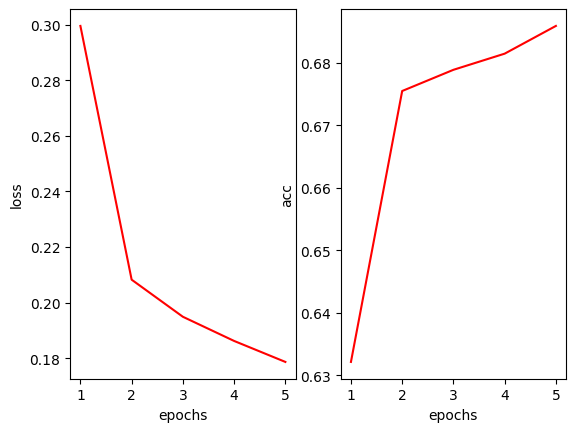

In [11]:
import matplotlib.pyplot as plt

x = list(range(1, len(hits_for_plot)+1))
plt.subplot(1,2,1)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(x, loss_for_plot, 'r')

plt.subplot(1,2,2)
plt.xlabel('epochs')
plt.ylabel('acc')
plt.plot(x, hits_for_plot, 'r')

plt.show()

## 预测

In [13]:
df = pd.read_csv('/kaggle/input/book-recommend-datasets/datasets/test.csv')
user_for_test = df['user_id'].tolist()

In [9]:
model = NCFModel(hidden_dim, traindataset.user_nums, traindataset.book_nums).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
crit = torch.nn.BCELoss()

model.load_state_dict(torch.load("/kaggle/input/book-recommend-datasets/model_7.h5"))

<All keys matched successfully>

In [18]:
from tqdm import tqdm

test_batch_size=512 #BATCH_SIZE

predict_item_id = []

def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i+n]

f = open('./submission.csv', 'w', encoding='utf-8')

# print(len(traindataset.user_book_map))

# os.pause()
# for user in user_for_test:
length=len(user_for_test)
for i in tqdm(range(length)):
    user=user_for_test[i]
    #将用户已经交互过的物品排除
    user_visited_items = traindataset.user_book_map[user]
    items_for_predict = list(set(range(traindataset.book_nums)) - set(user_visited_items))
    # print(items_for_predict)
    results = []
    user = torch.IntTensor([user]).to(device)

    for batch in chunks(items_for_predict, test_batch_size):
        batch = torch.IntTensor(batch).unsqueeze(0).to(device)
        result = model.predict(user, batch).view(-1).detach()#.cpu()
        results.append(result)

    results = torch.cat(results, dim=-1)
    predict_item_id = (-results).argsort()[:10]
    list(map(lambda x: f.write('{},{}\n'.format(user.cpu().item(), x)), predict_item_id))

f.flush()
f.close()

100%|██████████| 53424/53424 [15:31<00:00, 57.37it/s]
